# Boston Housing Dataset

In this notebook, we will explore the Boston Housing dataset using linear regression. The dataset contains information about various features of houses in Boston and their corresponding prices.

## First steps

In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml

In [3]:
# Load dataset
boston = fetch_openml("boston", version=1, as_frame=True)
df = boston.frame

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## Exploratory Data Analysis

### Initial Exploration

We start by looking at the structure and basic stats of the dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   CRIM     506 non-null    float64 
 1   ZN       506 non-null    float64 
 2   INDUS    506 non-null    float64 
 3   CHAS     506 non-null    category
 4   NOX      506 non-null    float64 
 5   RM       506 non-null    float64 
 6   AGE      506 non-null    float64 
 7   DIS      506 non-null    float64 
 8   RAD      506 non-null    category
 9   TAX      506 non-null    float64 
 10  PTRATIO  506 non-null    float64 
 11  B        506 non-null    float64 
 12  LSTAT    506 non-null    float64 
 13  MEDV     506 non-null    float64 
dtypes: category(2), float64(12)
memory usage: 49.0 KB


In [5]:
df.describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.554695,6.284634,68.574901,3.795043,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.115878,0.702617,28.148861,2.105710,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.624000,6.623500,94.075000,5.188425,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,711.000000,22.000000,396.900000,37.970000,50.000000


In [6]:
# Check for missing values
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

There is not missing values in the dataset, so we can proceed with the analysis.

### Plot feature distributions and relationships

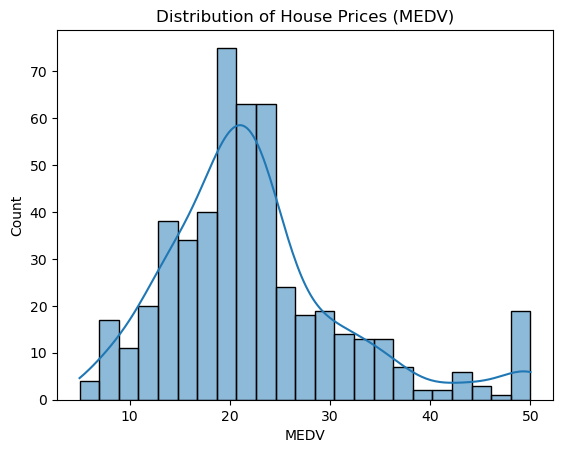

In [7]:
sns.histplot(df["MEDV"], kde=True)
plt.title("Distribution of House Prices (MEDV)")
plt.show()

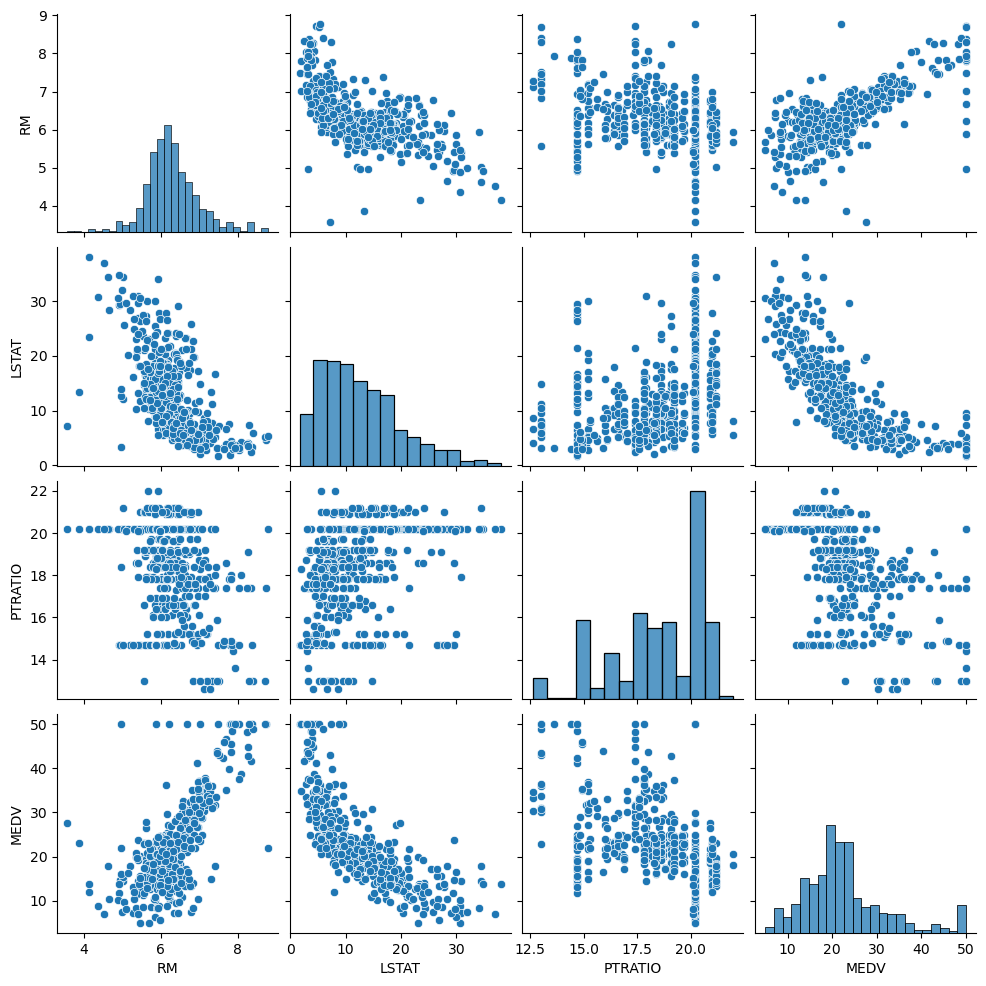

In [8]:
sns.pairplot(df[['RM', 'LSTAT', 'PTRATIO', 'MEDV']])

## Correlation Analysis

In [9]:
# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Focus on correlations with the target
medv_corr = corr_matrix['MEDV'].sort_values(ascending=False)

# Display the top correlations
print(medv_corr)

MEDV       1.000000
RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
AGE       -0.376955
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: MEDV, dtype: float64


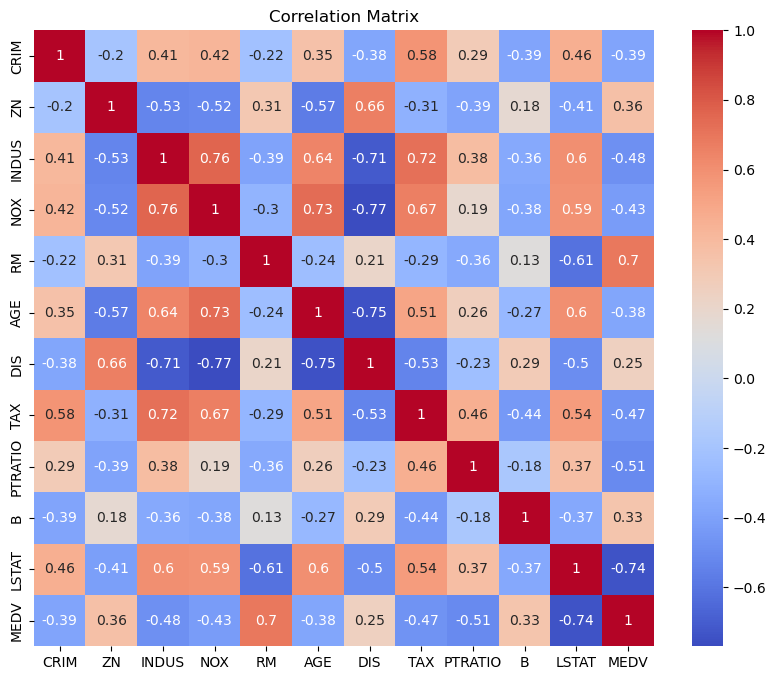

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

### Checking for Multicollinearity

Before fitting a linear regression model, we check wheter any of the features are highly correlated with each other. This is known as multicollinearity, and it can affect the stability of the regression coefficients. We will use the [Variance Inflation Factor (VIF)](https://en.wikipedia.org/wiki/Variance_inflation_factor) to check for multicollinearity.

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [12]:
# Subset selected features
X = df[['RM', 'ZN', 'B', 'LSTAT', 'PTRATIO']].copy()

X = sm.add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]

vif_data

,Feature,VIF
0,const,348.778892
1,RM,1.689777
2,ZN,1.311070
3,B,1.181616
4,LSTAT,2.013475
5,PTRATIO,1.298769


All features have VIF < 5, so there is no problematic multicollinearity. The features are safe to use in a linear regression model.

## Fitting a Linear Regression Model

### Train-test split

In [13]:
from sklearn.model_selection import train_test_split

# Features and target
X = df[['RM', 'ZN', 'B', 'LSTAT', 'PTRATIO']]
y = df['MEDV']

# Split the dataset (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Fit the model

We will use LinearRegression from scikit-learn

In [14]:
from sklearn.linear_model import LinearRegression

# Initialize and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [26]:
# Coefficients and intercept (declaring a function for further use)
def print_model_coefficients(model):
    coefficients = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_
    })

    print("Intercept (Bias):", model.intercept_, '\n', coefficients)

In [27]:
print_model_coefficients(model)

Intercept (Bias): 12.137034391483109 
    Feature  Coefficient
0       RM     4.696085
1       ZN    -0.018941
2        B     0.012284
3    LSTAT    -0.567154
4  PTRATIO    -0.874557


## Evaluating the Model

We will evaluate the model using the following metrics:
- Mean Absolute Error (MAE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- R-squared (R²)

In [28]:
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error,
    root_mean_squared_error, r2_score
)

def print_metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean absolute error: {mae:.2f}")
    print(f"Mean squared error: {mse:.2f}")
    print(f"Root mean squared error: {rmse:.2f}")
    print(f"R2: {r2:.2f}")

In [29]:
# Predict on test set
y_pred = model.predict(X_test)

print_metrics(y_test, y_pred)

Mean absolute error: 3.53
Mean squared error: 26.21
Root mean squared error: 5.12
R2: 0.65


R2 score is 0.65, which means that the model explains 65% of the variance in house prices. This is a decent score, but there is room for improvement.

## Trying to improve the model

### Feature Standardization

Feature standardization can help improve the performance of the model, especially when the features have different scales. We will use StandardScaler from scikit-learn to standardize the features.

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

Training the model again with standardized features.

In [37]:
new_model = LinearRegression()
new_model.fit(X_train_scaled, y_train)

LinearRegression()

In [38]:
# Predict on test set
y_pred = new_model.predict(X_test_scaled)

print_metrics(y_test, y_pred)

Mean absolute error: 4.15
Mean squared error: 28.71
Root mean squared error: 5.36
R2: 0.61


Now the R2 score is 0.61, which is slightly worse than the previous model. This indicates that standardization did not improve the model performance in this case, so we will return to the previous model.

## Conclusion

In this notebook, we explored the Boston Housing dataset using linear regression. We performed exploratory data analysis, checked for multicollinearity, fitted a linear regression model, and evaluated its performance. We also tried to standardize the features to improve the model performance, but it didn't bring any significant improvement. The final model achieves an R² score of 0.65, meaning it explains approximately 65% of the variance in housing prices. While this is a solid result for a basic linear model, further improvements could be achieved using regularization techniques, polynomial features, or more advanced models such as decision trees or gradient boosting but those are beyond the scope of this notebook.